# Importing

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from skimage.feature import hog

# Preprocessing Image 

In [2]:
def preprocessing(image_path):
    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img , (64,64) )
    return img

# Import Train And Test

In [3]:
data_path = 'C:\\Users\\DELL\\ML\\fruits-360\\train2\\only train2'
images = []
labels = []
for dir in os.listdir(data_path):
    if not dir.startswith('.'):
        path = os.path.join(data_path, dir)
        print(dir)

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img=preprocessing(img_path)
            images.append(img)
            labels.append(dir)

numpyArray1 = np.array(images)
y_train=np.array(labels)

Apple Red 1
Banana
Cherry 2
Mango
Orange


In [4]:
data_path = 'C:\\Users\\DELL\\ML\\fruits-360\\test2\\new predict'
images2 = []
labels2 = []
for dir in os.listdir(data_path):
    if not dir.startswith('.'):
        path = os.path.join(data_path, dir)
        print(dir)

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img=preprocessing(img_path)
            images2.append(img)
            labels2.append(dir)

numpyArray2 = np.array(images2)
y_test=np.array(labels2)

Apple Red 1
Banana
Cherry 2
Mango
Orange


# Extracting Features By HOG

In [5]:
# Function to extract HOG features from an image
def extract_hog_features(image):
    _,hog_features = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2),block_norm='L2-Hys',visualize=True)
    return hog_features.flatten()

# Apply HOG For Kmeans

In [6]:
X_train=[extract_hog_features(image) for image in numpyArray1]
X_test=[extract_hog_features(image) for image in numpyArray2]


In [7]:
kmeans_model = KMeans(n_clusters=5, random_state=40,n_init=10)
kmeans_model.fit(X_train)

KMeans(n_clusters=5, n_init=10, random_state=40)

In [8]:
cluster_labels = kmeans_model.labels_
cluster_labels

array([0, 0, 0, ..., 4, 4, 4])

# Visualize the cluster centers samples 

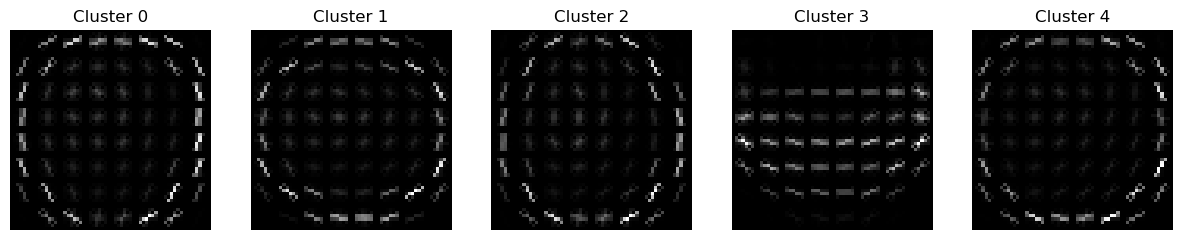

In [9]:
# Visualize the cluster centers (representative images)
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):  # You specified n_clusters=5
    center_image = kmeans_model.cluster_centers_[i]
    ax[i].imshow(center_image.reshape(64, 64), cmap='gray')  # Adjust the shape according to the number of HOG features
    ax[i].axis('off')
    ax[i].set_title(f'Cluster {i}')

plt.show()


# Importing

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, log_loss

from sklearn.preprocessing import label_binarize
from itertools import cycle

# Logistic Regression

In [11]:
logreg_model = LogisticRegression(multi_class='ovr', max_iter=1000)
history = logreg_model.fit(X_train, y_train)


# Loss Curve

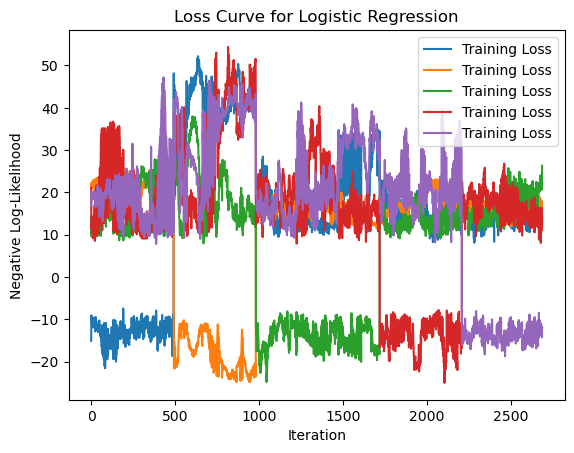

In [12]:
# Plot the loss curve
loss_values = -np.array(history.decision_function(X_train))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Negative Log-Likelihood')
plt.title('Loss Curve for Logistic Regression')
plt.legend()
plt.show()

# Accuracy After LogisticRegression

In [13]:
y_pred = logreg_model.predict(X_test)
accuracy = accuracy_score(y_test , y_pred)

print("accuracy:", accuracy*100)

accuracy: 97.77034559643255


# Predicting New Input

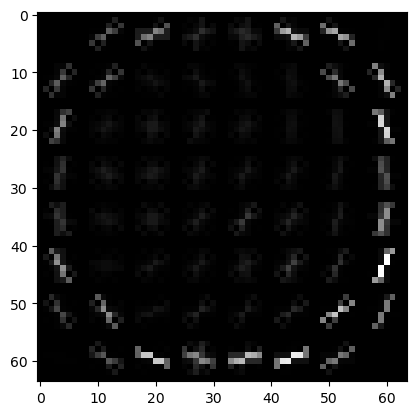

In [14]:
img = preprocessing("C:\\Users\\DELL\\ML\\fruits-360\\test2\\new 2\\48_100.jpg")
img=extract_hog_features(np.array(img))
plt.imshow(img.reshape(64, 64), cmap='gray')
img=[img]
# plt.imshow(img)

In [15]:
y = logreg_model.predict(img)
print(y[0])

Orange


# Confusion Matrix: 

In [16]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
pd.DataFrame(conf_matrix).style.background_gradient(cmap = "inferno")

Confusion Matrix:


,0,1,2,3,4
0,146,0,0,7,10
1,0,165,0,0,0
2,0,0,245,0,0
3,0,0,3,162,0
4,0,0,0,0,159


# ROC Curve

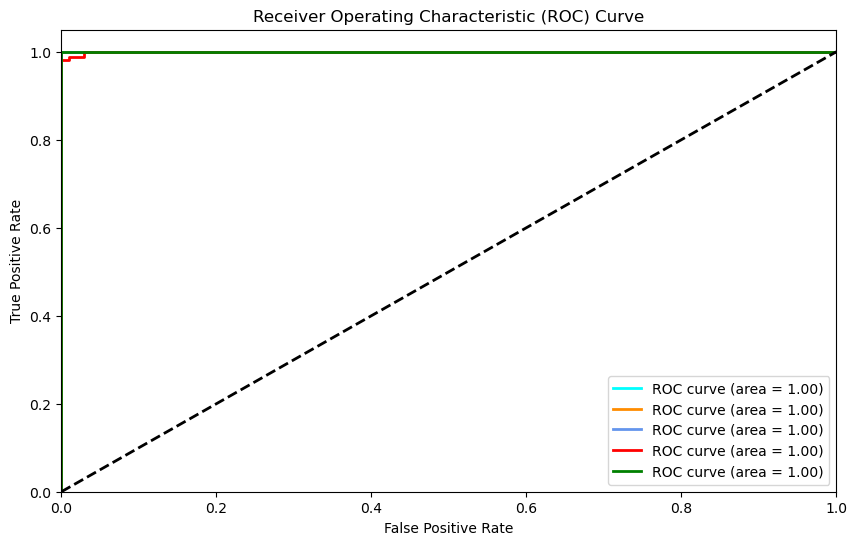

In [17]:
# Plot ROC curve
if len(np.unique(y_test)) > 2:
    # If multiclass, convert y_test to one-hot encoding
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test_bin.shape[1]
else:
    n_classes = 1
    y_test_bin = y_test

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], logreg_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 6))

# Plotting each class's ROC curve
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()